<a href="https://colab.research.google.com/github/Saksham-tyagi1/NBA-Analysis/blob/main/NBA_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
pd.set_option("display.max_colwidth", 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/optimized_data.parquet')

# Utility Functions


In [ ]:
def get_summary(df):
    print("Numerical Summary:")
    display(df.describe().T)
    print("\nCategorical Summary:")
    display(df.describe(include=['category', 'object']).T)


In [ ]:
def unique_values_summary(df):
    for col in df.select_dtypes(include=['category', 'object']).columns:
        print(f"{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().head(), "\n")


In [ ]:
def plot_correlation_heatmap(df, cols=None):
    plt.figure(figsize=(10, 8))
    corr_matrix = df[cols].corr() if cols else df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
def plot_categorical_counts(df, cols):
    for col in cols:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f'{col} Distribution')
        plt.xticks(rotation=45)
        plt.show()
def plot_boxplots(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'{col} Box Plot')
        plt.xlabel(col)
        plt.show()
def plot_histograms(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'{col} Distribution')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
def plot_scatter(df, x_col, y_col, hue_col=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_col, y=y_col, hue=hue_col, data=df, alpha=0.5)
    plt.title(f'{x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()
def get_numerical_columns(df):
    numerical_cols = df.select_dtypes(include='number').columns
    return numerical_cols



In [ ]:

def plot_categorical_counts_with_other(df, col, top_n):
    # Get the top N categories
    top_categories = df[col].value_counts().nlargest(top_n).index

    # Create a new column with "Other" for less frequent categories
    df[col + '_modified'] = df[col].apply(lambda x: x if x in top_categories else 'Other')

    # Count the values again in the modified column to ensure top N + "Other" are shown
    category_order = df[col + '_modified'].value_counts().index

    # Plot the count plot with modified column and category order
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col + '_modified', order=category_order)
    plt.title(f'{col} Distribution (Top {top_n} + Other)')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def display_value_counts(df, columns, top_n=10):
    for col in columns:
        print(f"\nValue counts for '{col}':")
        print(df[col].value_counts().head(top_n))
        print("-" * 50)



In [ ]:
def find_redundant_features(df, threshold=None):
    redundant_features = {
        'highly_correlated_pairs': [],
        'redundant_categorical_pairs': {}
    }
    numerical_df = df.select_dtypes(include='number')
    correlation_matrix = numerical_df.corr()

    if threshold is not None:
        for col1 in correlation_matrix.columns:
            for col2 in correlation_matrix.columns:
                if col1 != col2 and correlation_matrix.loc[col1, col2] > threshold:
                    redundant_features['highly_correlated_pairs'].append(
                        (col1, col2, correlation_matrix.loc[col1, col2])
                    )
    else:
        redundant_features['all_correlations'] = correlation_matrix

    categorical_columns = df.select_dtypes(include='category').columns
    for i, col1 in enumerate(categorical_columns):
        for col2 in categorical_columns[i+1:]:
            if df[col1].equals(df[col2]):
                redundant_features['redundant_categorical_pairs'][col1] = col2
            elif set(df[col1].unique()).issubset(df[col2].unique()):
                redundant_features['redundant_categorical_pairs'][col1] = col2
            elif set(df[col2].unique()).issubset(df[col1].unique()):
                redundant_features['redundant_categorical_pairs'][col2] = col1

    return redundant_features


# Confirming Feature Relevance


In [ ]:

columns_to_check = ['SEASON_1', 'SEASON_2']
display_value_counts(df, columns_to_check)



Value counts for 'SEASON_1':
SEASON_1
2024    20134694
Name: count, dtype: int64
--------------------------------------------------

Value counts for 'SEASON_2':
SEASON_2
2023-24    20134694
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
df.drop(columns=['SEASON_1', 'SEASON_2'], inplace=True)


In [ ]:
find_redundant_features(df,0.9)

{'highly_correlated_pairs': [('DRBC', 'RBC', 0.9138860474946391),
  ('RBC', 'DRBC', 0.9138860474946391),
  ('TCHS', 'PASS', 0.9622291834212389),
  ('PASS', 'TCHS', 0.9622291834212389),
  ('FGM', 'FGA', 0.9916539767007261),
  ('FGA', 'FGM', 0.9916539767007261),
  ('FG_PCT_y', 'EFG_PCT', 0.9298114423602944),
  ('EFG_PCT', 'FG_PCT_y', 0.9298114423602944),
  ('HOME_SCORE', 'AWAY_SCORE', 0.9320620643980921),
  ('AWAY_SCORE', 'HOME_SCORE', 0.9320620643980921)],
 'redundant_categorical_pairs': {}}

In [ ]:
df['EXPECTED_SCOREMARGIN'] = df['HOME_SCORE'] - df['AWAY_SCORE']
df['SCOREMARGIN_INCONSISTENT'] = df['SCOREMARGIN'] != df['EXPECTED_SCOREMARGIN']
num_inconsistent = df['SCOREMARGIN_INCONSISTENT'].sum()
print(f"Number of inconsistent SCOREMARGIN values: {num_inconsistent}")
event_margin_analysis = df.groupby(['GAME_ID', 'EVENT_TYPE']).agg(
    avg_scoremargin=('SCOREMARGIN', 'mean'),
    min_scoremargin=('SCOREMARGIN', 'min'),
    max_scoremargin=('SCOREMARGIN', 'max')
).reset_index()

print("SCOREMARGIN Analysis by Event:")
print(event_margin_analysis.head())
quarter_margin_analysis = df.groupby(['GAME_ID', 'QUARTER']).agg(
    avg_scoremargin=('SCOREMARGIN', 'mean'),
    min_scoremargin=('SCOREMARGIN', 'min'),
    max_scoremargin=('SCOREMARGIN', 'max')
).reset_index()

print("SCOREMARGIN Analysis by Quarter:")
print(quarter_margin_analysis.head())


Number of inconsistent SCOREMARGIN values: 20134694


<ipython-input-13-1d3953e57e75>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_margin_analysis = df.groupby(['GAME_ID', 'EVENT_TYPE']).agg(


SCOREMARGIN Analysis by Event:
    GAME_ID   EVENT_TYPE  avg_scoremargin  min_scoremargin  max_scoremargin
0  22300589  Made Shot    1.366197        -9.0              13.0           
1  22300589  Missed Shot  1.366197        -9.0              13.0           
2  22300961  Made Shot   -9.123288        -25.0             5.0            
3  22300961  Missed Shot -9.123288        -25.0             5.0            
4  22300962  Made Shot   -7.333333        -21.0             5.0            
SCOREMARGIN Analysis by Quarter:
    GAME_ID  QUARTER  avg_scoremargin  min_scoremargin  max_scoremargin
0  22300589  1        1.366197        -9.0              13.0           
1  22300589  2        1.366197        -9.0              13.0           
2  22300589  3        1.366197        -9.0              13.0           
3  22300589  4        1.366197        -9.0              13.0           
4  22300961  1       -9.123288        -25.0             5.0            


In [ ]:

df[['SCOREMARGIN', 'HOME_SCORE', 'AWAY_SCORE',]].head(50)


,SCOREMARGIN,HOME_SCORE,AWAY_SCORE
0,2.0,0,2
1,-1.0,3,2
2,2.0,3,5
3,-1.0,6,5
4,1.0,6,7
5,4.0,6,10
6,4.0,8,12
7,2.0,10,12
8,5.0,10,15
9,8.0,11,19


In [ ]:
nan_count = df['SCOREMARGIN'].isna().sum()
print("Number of NaN values in SCOREMARGIN:", nan_count)


Number of NaN values in SCOREMARGIN: 815109


#EDA

In [ ]:
numerical_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()


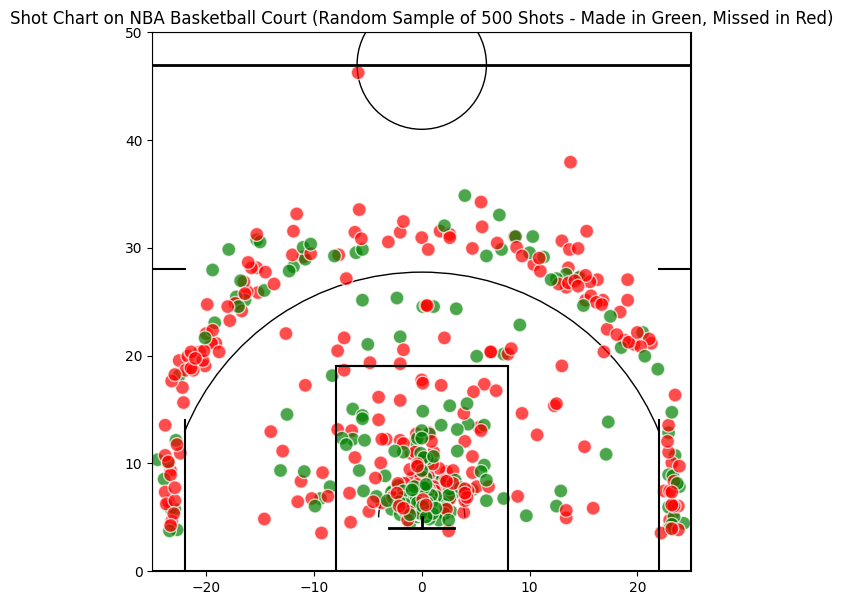

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc


# Sample data if needed (optional)
df_sampled = df.sample(n=500, random_state=42)  # Adjust 'n' if you want more or fewer shots

def draw_basketball_court(ax=None):
    if ax is None:
        ax = plt.gca()

    # Basketball court outline and features
    plt.plot([-25, 25, 25, -25, -25], [0, 0, 50, 50, 0], color='black')  # Court boundary
    center_circle = plt.Circle((0, 47), 6, color='black', fill=False)  # Center circle
    ax.add_artist(center_circle)
    plt.plot([-8, -8, 8, 8, -8], [0, 19, 19, 0, 0], color='black')  # Free throw lane
    plt.plot([-8, 8], [19, 19], color='black')  # Top of free throw lane
    restricted_area = Arc((0, 5), 8, 8, angle=0, theta1=0, theta2=180, color='black')
    ax.add_artist(restricted_area)  # Restricted area arc
    plt.plot([-3, 3], [4, 4], color='black', linewidth=2)  # Backboard
    plt.plot([0, 0], [4, 5], color='black', linewidth=2)  # Rim
    three_pt_arc = Arc((0, 4), 47.5, 47.5, angle=0, theta1=22, theta2=158, color='black')
    ax.add_artist(three_pt_arc)  # Three-point arc
    plt.plot([-22, -22], [0, 14], color='black')  # Left 3-point line
    plt.plot([22, 22], [0, 14], color='black')  # Right 3-point line
    plt.plot([-25, -22], [28, 28], color='black')  # Left side 3-point arc
    plt.plot([22, 25], [28, 28], color='black')  # Right side 3-point arc
    plt.plot([-25, 25], [47, 47], color='black', linewidth=2)  # Center court line

plt.figure(figsize=(12, 7))
ax = plt.gca()
draw_basketball_court(ax)

plt.scatter(df_sampled['LOC_X'], df_sampled['LOC_Y'],
            c=df_sampled['SHOT_MADE'].map({True: 'green', False: 'red'}),
            alpha=0.7, edgecolors='w', s=100)  # Adjusted point size and transparency


plt.xlim(-25, 25)
plt.ylim(0, 50)
plt.title(f'Shot Chart on NBA Basketball Court (Random Sample of 500 Shots - Made in Green, Missed in Red)')
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


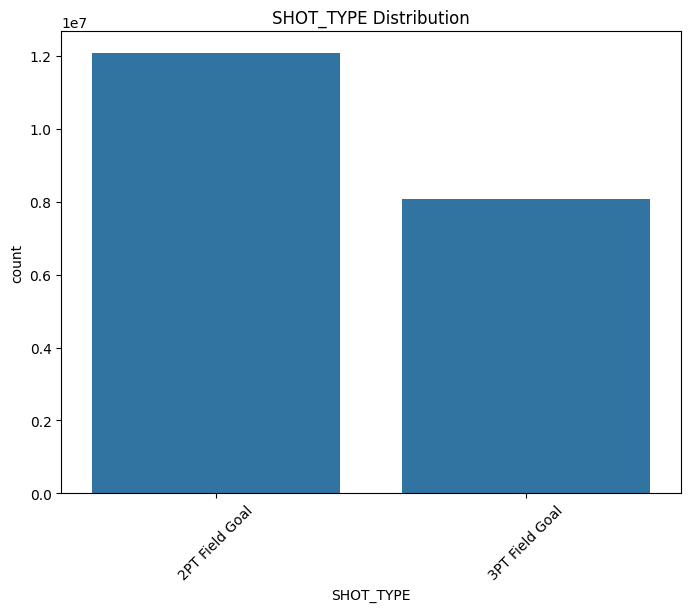

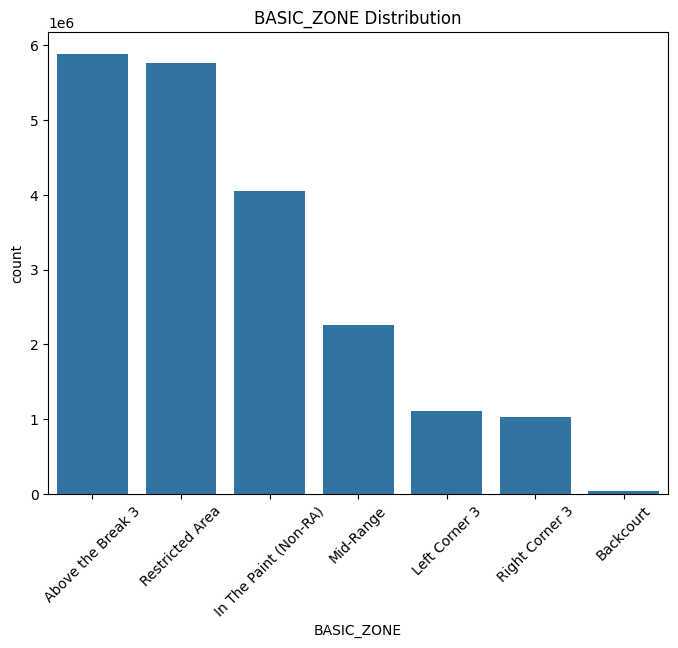

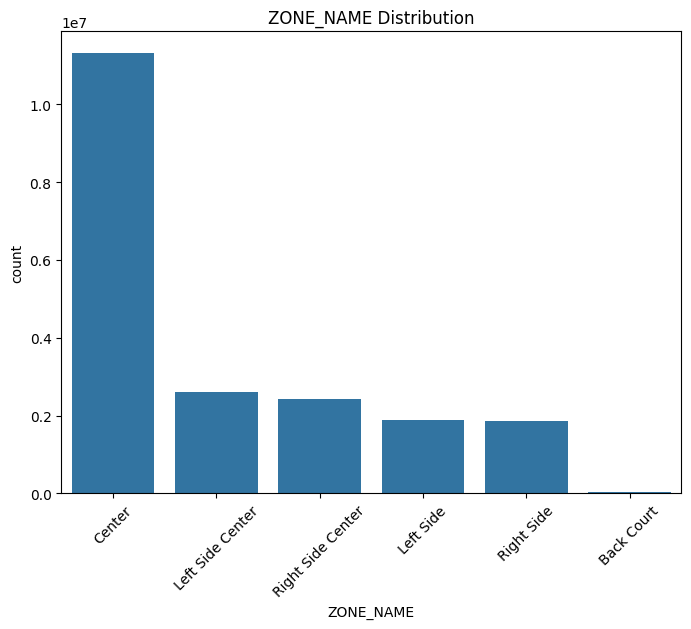

In [ ]:

categorical_features = ['SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', ]

plot_categorical_counts(df, categorical_features)


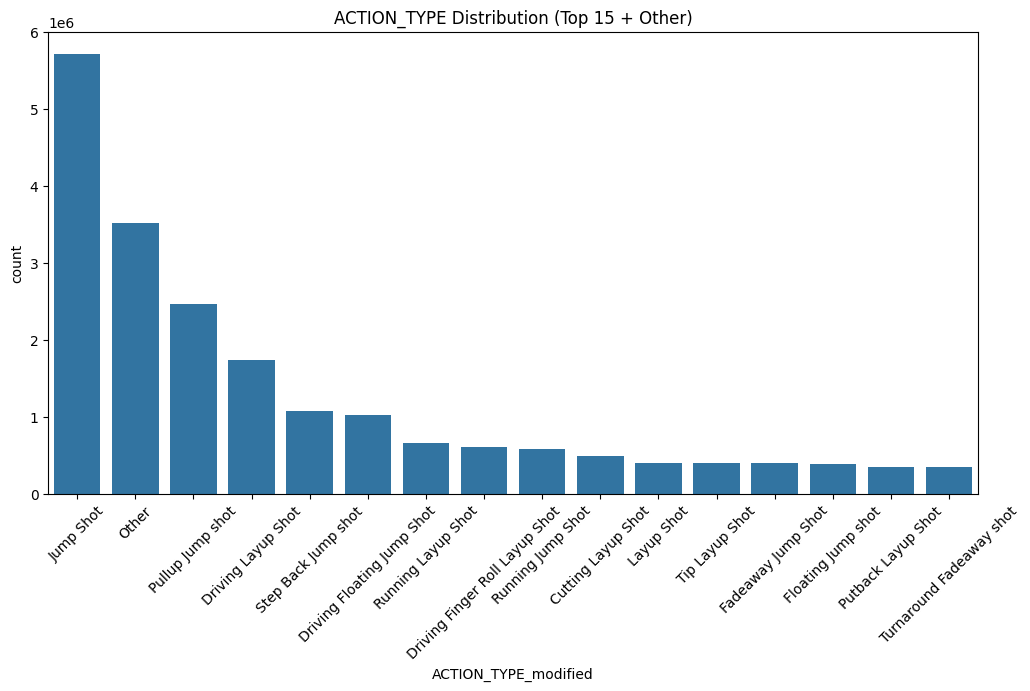

In [ ]:
plot_categorical_counts_with_other(df, 'ACTION_TYPE', top_n=15)

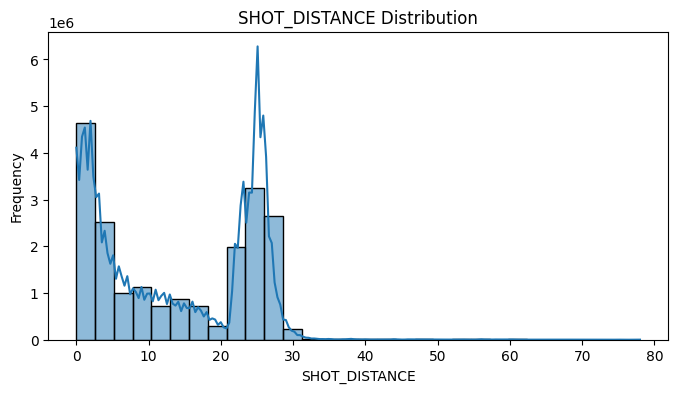

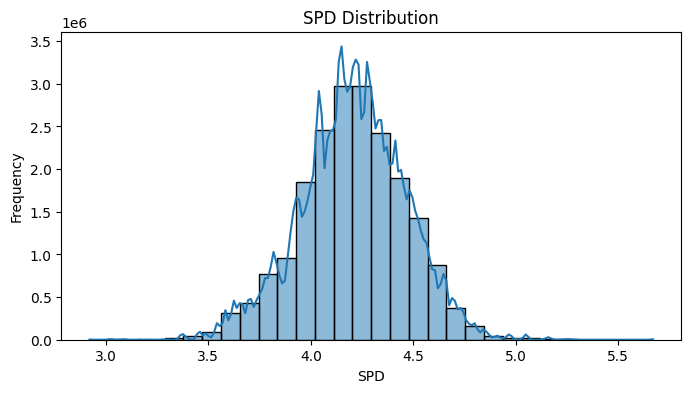

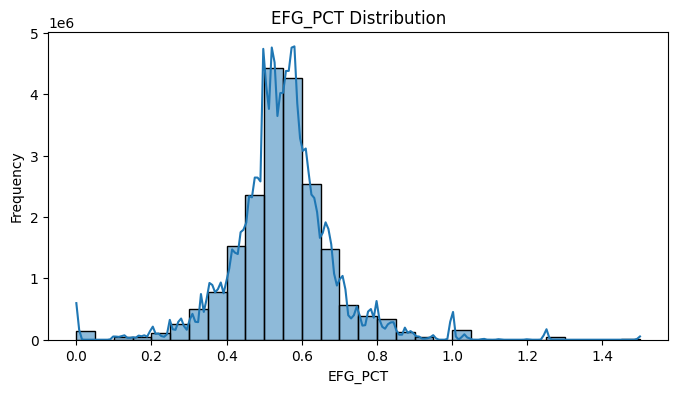

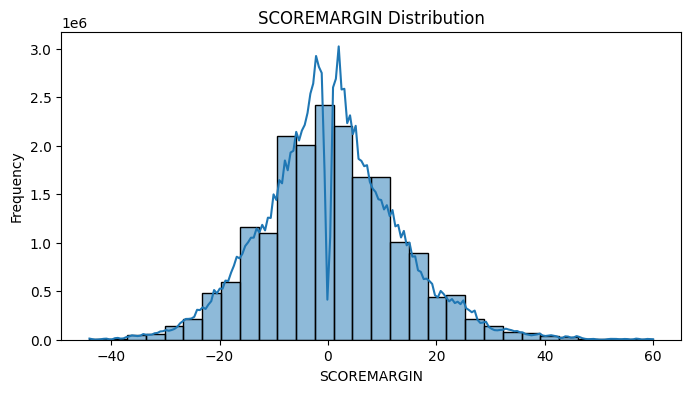

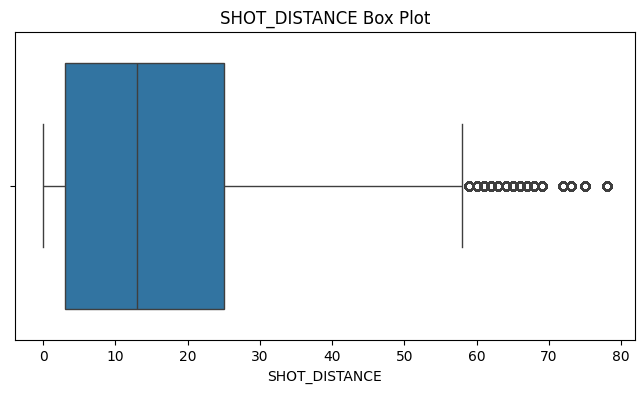

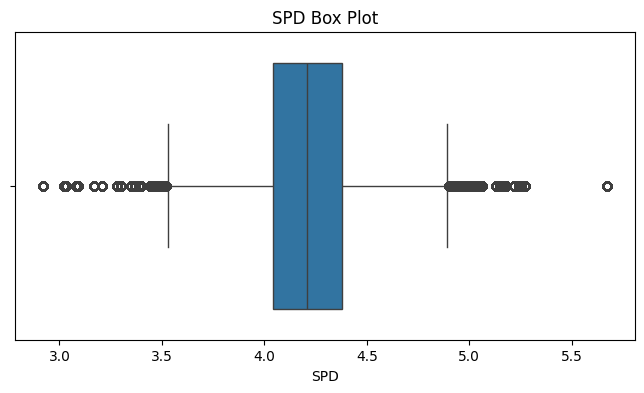

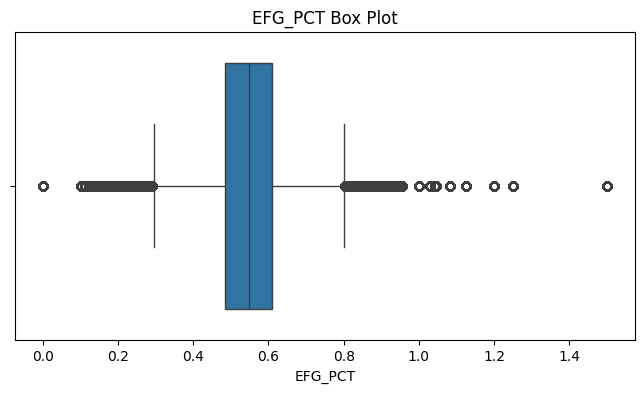

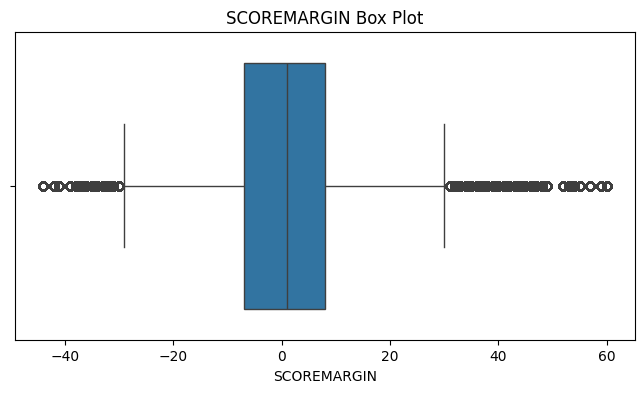

In [ ]:

key_features = ['SHOT_DISTANCE', 'SPD', 'EFG_PCT', 'SCOREMARGIN']
plot_histograms(df, key_features)
plot_boxplots(df, key_features)


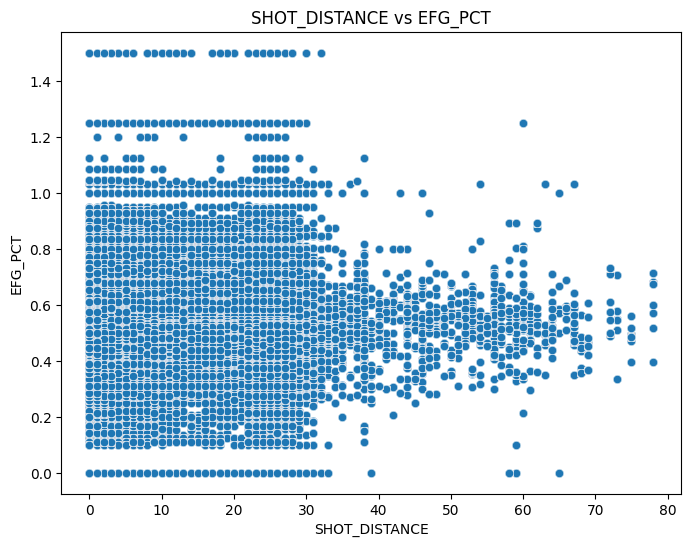

In [ ]:
plot_scatter(df, x_col='SHOT_DISTANCE', y_col='EFG_PCT')


In [ ]:
df.columns

Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT',
       'SPD', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS', 'SAST', 'PASS', 'AST',
       'FGM', 'FGA', 'FG_PCT_y', 'DFGM', 'DFGA', 'DFG_PCT', 'SHOT_CLOCK_RANGE',
       'SCORE', 'SCOREMARGIN', 'EFG_PCT', 'PERSON1TYPE', 'PERSON2TYPE',
       'PERSON3TYPE', 'LOC_X_BIN', 'LOC_Y_BIN', 'SHOT_DISTANCE_BIN',
       'HOME_SCORE', 'AWAY_SCORE'],
      dtype='object')

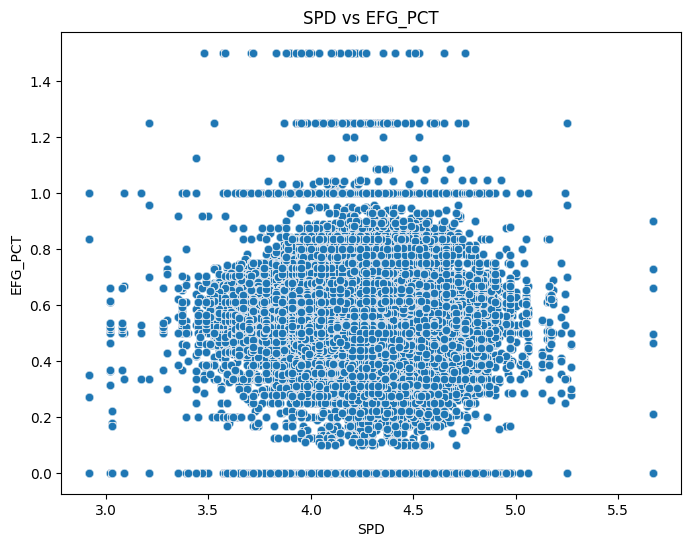

In [ ]:
plot_scatter(df, x_col='SPD', y_col='EFG_PCT')


In [ ]:
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df = df.sort_values(by='GAME_DATE')


In [ ]:
# Calculate daily averages for EFG_PCT and SCOREMARGIN
temporal_data = df.groupby('GAME_DATE').agg({
    'EFG_PCT': 'mean',
    'SCOREMARGIN': 'mean'
}).reset_index()


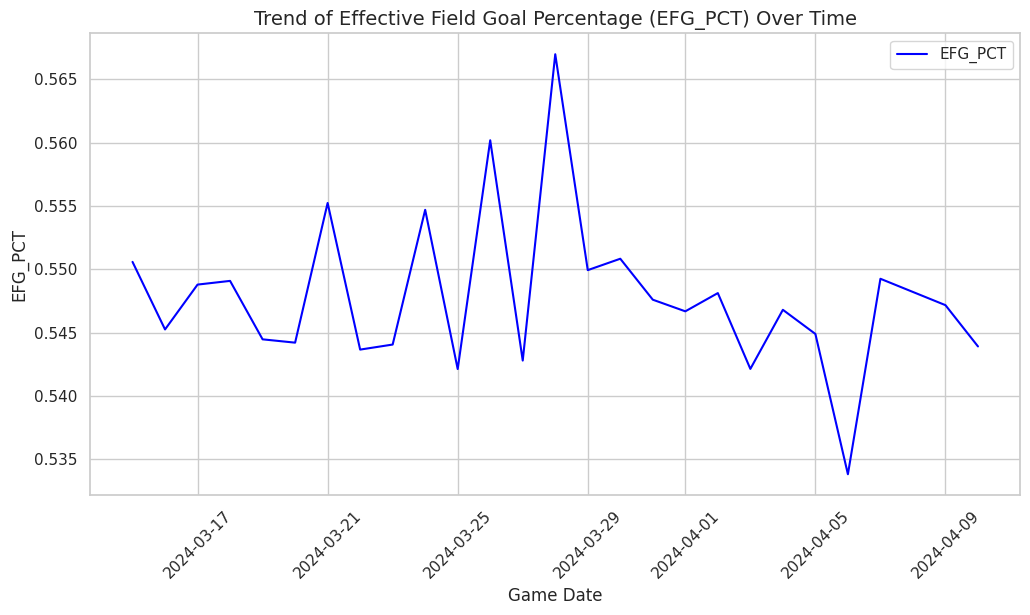

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='GAME_DATE', y='EFG_PCT', data=temporal_data, label='EFG_PCT', color='blue')
plt.title('Trend of Effective Field Goal Percentage (EFG_PCT) Over Time', fontsize=14)
plt.xlabel('Game Date', fontsize=12)
plt.ylabel('EFG_PCT', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [ ]:
# Group data by SHOT_DISTANCE and SHOT_TYPE
distance_analysis = df.groupby(['SHOT_DISTANCE', 'SHOT_TYPE']).agg({
    'SHOT_MADE': 'mean',  # Shooting accuracy
    'SHOT_MADE': 'count'  # Number of attempts
}).rename(columns={'SHOT_MADE': 'Accuracy', 'SHOT_MADE': 'Attempts'}).reset_index()


<ipython-input-17-9a8140abae46>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_analysis = df.groupby(['SHOT_DISTANCE', 'SHOT_TYPE']).agg({


<ipython-input-28-554e0300f5b3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_analysis.groupby('SHOT_TYPE')['Accuracy']


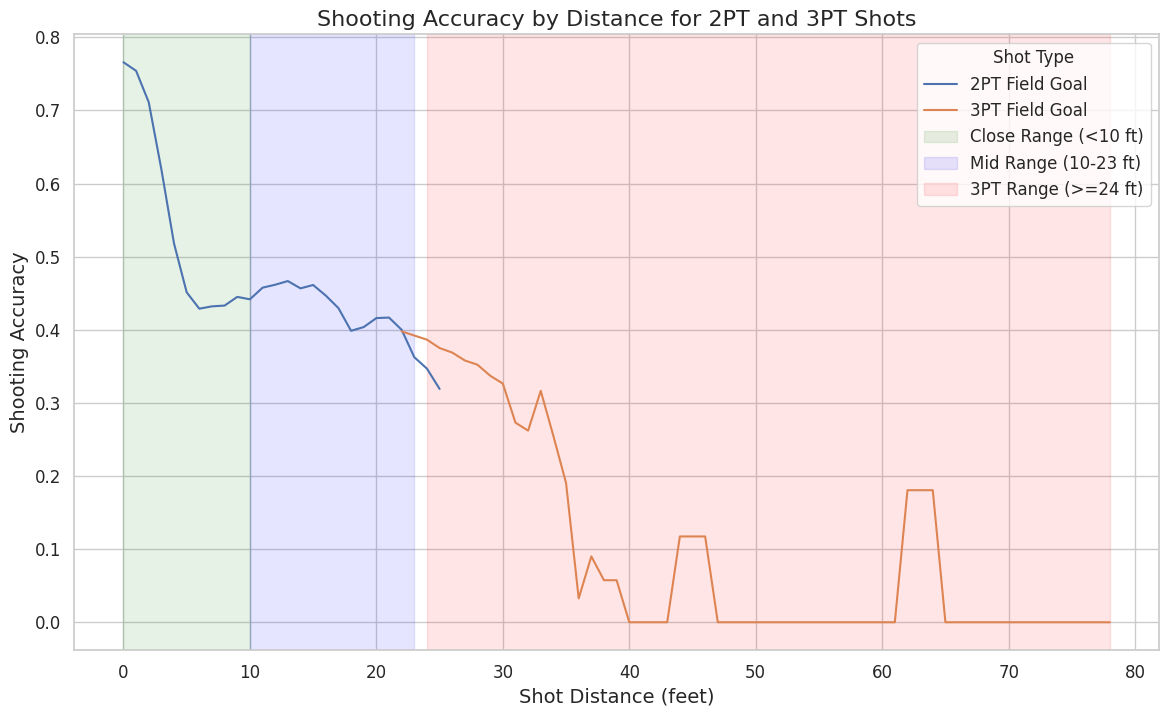

In [ ]:

distance_analysis['Accuracy_Smoothed'] = (
    distance_analysis.groupby('SHOT_TYPE')['Accuracy']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

plt.figure(figsize=(14, 8))
sns.lineplot(data=distance_analysis, x='SHOT_DISTANCE', y='Accuracy_Smoothed', hue='SHOT_TYPE')

plt.axvspan(0, 10, color='green', alpha=0.1, label='Close Range (<10 ft)')
plt.axvspan(10, 23, color='blue', alpha=0.1, label='Mid Range (10-23 ft)')
plt.axvspan(24, max(distance_analysis['SHOT_DISTANCE']), color='red', alpha=0.1, label='3PT Range (>=24 ft)')

plt.title('Shooting Accuracy by Distance for 2PT and 3PT Shots', fontsize=16)
plt.xlabel('Shot Distance (feet)', fontsize=14)
plt.ylabel('Shooting Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Shot Type', fontsize=12, loc='upper right')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# 3PT vs 2PT reliance
team_shot_reliance = df.groupby('TEAM_NAME').apply(
    lambda x: pd.Series({
        '3PT_Shot_Percentage': (x['SHOT_TYPE'] == '3PT Field Goal').mean() * 100,
        '2PT_Shot_Percentage': (x['SHOT_TYPE'] == '2PT Field Goal').mean() * 100,
        'Average_EFG_PCT': x['EFG_PCT'].mean()
    })
).reset_index()

# Shot zone distribution
team_shot_zones = df.groupby(['TEAM_NAME', 'BASIC_ZONE']).size().reset_index(name='Shot_Count')

# Normalize shot counts by team to get percentages
team_shot_zones['Zone_Percentage'] = team_shot_zones.groupby('TEAM_NAME')['Shot_Count'].transform(lambda x: x / x.sum() * 100)


<ipython-input-29-f80124f764d3>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_shot_reliance = df.groupby('TEAM_NAME').apply(


In [ ]:
# Verify the shot reliance calculations
team_shot_reliance = df.groupby('TEAM_NAME').apply(
    lambda x: pd.Series({
        '3PT_Shot_Percentage': (x['SHOT_TYPE'] == '3PT Field Goal').mean() * 100,
        '2PT_Shot_Percentage': (x['SHOT_TYPE'] == '2PT Field Goal').mean() * 100
    })
).reset_index()




<ipython-input-34-4a737da12205>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_shot_reliance = df.groupby('TEAM_NAME').apply(


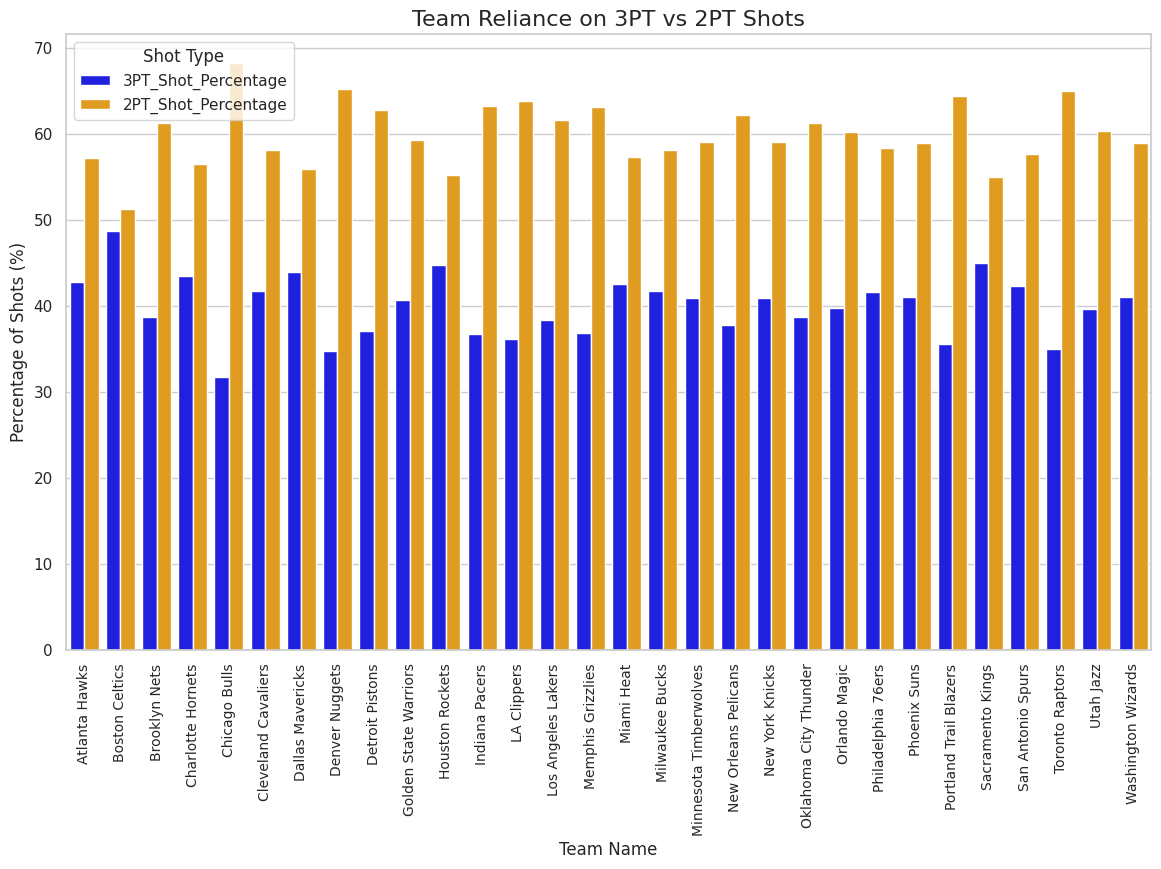

In [ ]:
# Reshape data for grouped bar plot
shot_reliance_melted = team_shot_reliance.melt(
    id_vars='TEAM_NAME',
    value_vars=['3PT_Shot_Percentage', '2PT_Shot_Percentage'],
    var_name='Shot_Type',
    value_name='Percentage'
)

# Plot grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=shot_reliance_melted,
    x='TEAM_NAME',
    y='Percentage',
    hue='Shot_Type',
    palette=['blue', 'orange']
)

plt.title('Team Reliance on 3PT vs 2PT Shots', fontsize=16)
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Percentage of Shots (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Shot Type')
plt.show()


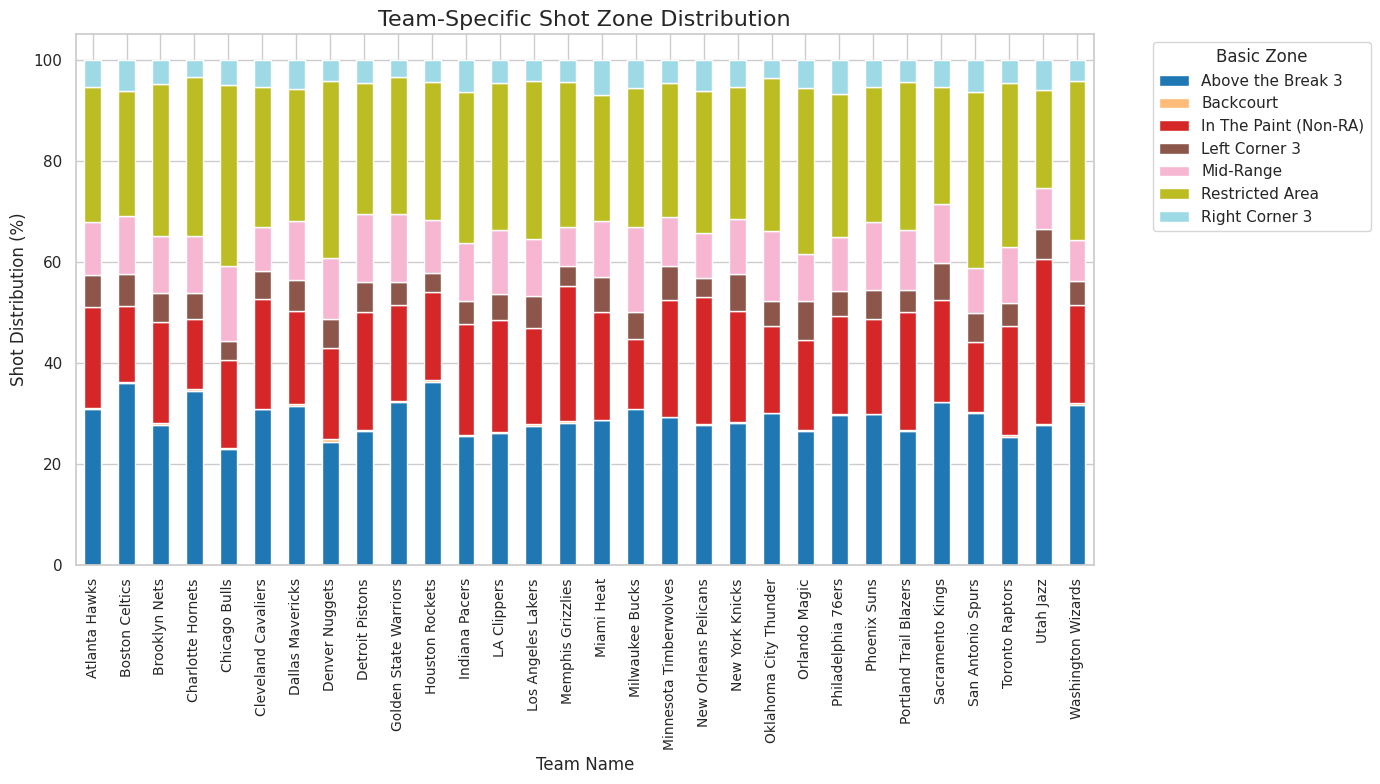

In [ ]:
# Pivot the shot zone data for visualization
shot_zone_pivot = team_shot_zones.pivot(index='TEAM_NAME', columns='BASIC_ZONE', values='Zone_Percentage').fillna(0)

# Plot shot zone preferences
shot_zone_pivot.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')

plt.title('Team-Specific Shot Zone Distribution', fontsize=16)
plt.xlabel('Team Name', fontsize=12)
plt.ylabel('Shot Distribution (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Basic Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
